# Toy data
> Randomly-spaced points on a hyperbolic branch

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.hyperdt.toy_data import generate_points_on_branch


In [3]:
# Generate 2 sets of points, for classification:

root = np.array([1.0, 0.0, 0.0])
points = []
labels = []
for i in range(3):
    points.append(
        generate_points_on_branch(
            root=root,
            direction=np.random.rand(3),
            num_points=100,
            noise_std=0.1,
        )
    )
    labels += [i] * 100

data = np.vstack(points)
labels = np.array(labels)


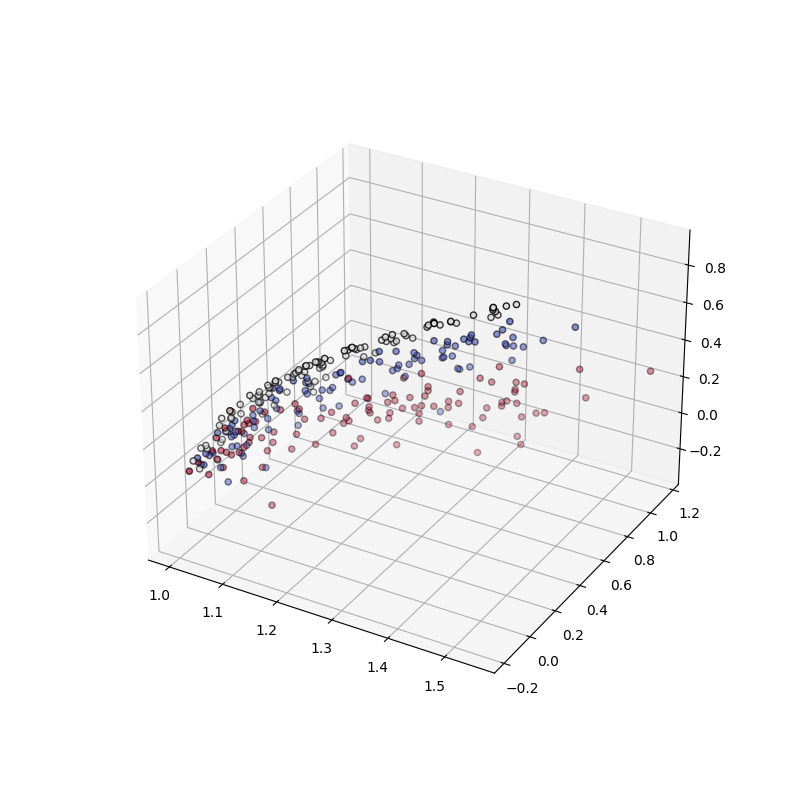

In [4]:
# Plot the points

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data[:, 0], data[:, 1], data[:, 2], c=labels, cmap="coolwarm", edgecolor="k"
)
plt.show()


In [5]:
# Try to classify using hyperbolic and regular decision trees

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from src.tree import HyperbolicDecisionTreeClassifier  # , DecisionTree
from src.forest import HyperbolicRandomForestClassifier

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

# Hyperparameters
MIN_SAMPLES = 2
MAX_DEPTH = 10
args = dict(
    min_samples_split=MIN_SAMPLES,
    min_samples_leaf=MIN_SAMPLES,
    max_depth=MAX_DEPTH,
)

# Fit a regular decision tree
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X_train, y_train)

# Fit a hyperbolic decision tree
hdt = HyperbolicDecisionTreeClassifier(**args)
hdt.fit(X_train, y_train)

# Control dt
hdt_control = HyperbolicDecisionTreeClassifier(hyperbolic=False, **args)
hdt_control.fit(X_train, y_train)

# Sklearn random forest
rf = RandomForestClassifier(n_estimators=1000, max_depth=4)
rf.fit(X_train, y_train)

# Hyperbolic random forest
hrf = HyperbolicRandomForestClassifier(
    n_estimators=1000, hyperbolic=True, **args
)
hrf.fit(X_train, y_train)

# Control hrf
hrf_control = HyperbolicRandomForestClassifier(
    n_estimators=1000, hyperbolic=False, **args
)
hrf_control.fit(X_train, y_train)

# Compare scores
print(
    f"Regular decision tree accuracy: {accuracy_score(y_test, dt.predict(X_test)):.3f}",
    f"Hyperbolic decision tree accuracy: {accuracy_score(y_test, hdt.predict(X_test)):.3f}",
    f"Hyperbolic decision tree accuracy (control): {accuracy_score(y_test, hdt_control.predict(X_test)):.3f}",
    f"Hyperbolic random forest accuracy: {accuracy_score(y_test, hrf.predict(X_test)):.3f}",
    f"Hyperbolic random forest accuracy (control): {accuracy_score(y_test, hrf_control.predict(X_test)):.3f}",
    sep="\n",
)


Regular decision tree accuracy: 0.567
Hyperbolic decision tree accuracy: 0.400
Hyperbolic decision tree accuracy (control): 0.267
Hyperbolic random forest accuracy: 0.350
Hyperbolic random forest accuracy (control): 0.267


In [6]:
# Try it on americangut

import anndata
import numpy as np

adata = anndata.read_h5ad(
    # "/home/phil/americangut/data/americangut_embeddings.h5ad"
    "/home/phil/americangut/data/big_table_with_embeddings.h5ad"
)

neg_master = ["no", "false", "i do not have this condition", "never"]

pos_master = [
    "yes",
    "true",
    "diagnosed by a medical professional (doctor, physician assistant)",
    "self-diagnosed",
    "diagnosed by an alternative medicine practitioner",
    "rarely (less than once/week)",
    "rarely (a few times/month)",
    "occasionally (1-2 times/week)",
    "regularly (3-5 times/week)",
    "daily",
]

nan_master = ["nan", "not provided", "not sure", "not collected", "unspecified"]


def classify(
    column,
    pos_vals=pos_master,
    neg_vals=neg_master,
    nan_vals=nan_master,
    data=adata.X.toarray(),
    balance=False,
    seed=None,
):
    vals = adata.obs[column].str.lower()
    nan_vals = vals.isna() | vals.isin(nan_vals)
    pos_vals = vals.isin(pos_vals)
    neg_vals = vals.isin(neg_vals)
    assert not (pos_vals & neg_vals).any()
    try:
        assert (pos_vals | neg_vals | nan_vals).all()
    except AssertionError:
        print(column)
        print(vals[~(pos_vals | neg_vals | nan_vals)])

    X = np.array(data)[~nan_vals]
    y = np.array(pos_vals)[~nan_vals]

    n_pos = y.sum()
    n_neg = (~y).sum()

    if balance:
        if seed is not None:
            np.random.seed(seed)
        # Balance the classes
        if n_pos > n_neg:
            drop = np.random.choice(
                np.where(y)[0], n_pos - n_neg, replace=False
            )
        elif n_neg > n_pos:
            drop = np.random.choice(
                np.where(~y)[0], n_neg - n_pos, replace=False
            )
        X = np.delete(X, drop, axis=0)
        y = np.delete(y, drop, axis=0)

    return X, y


In [7]:
X_ibd, y_ibd = classify(
    "ibd", data=adata.obsm["hyp_mix_16"], balance=True, seed=42
)


In [8]:
# Compare scores for different classifiers

X_train, X_test, y_train, y_test = train_test_split(
    X_ibd, y_ibd, test_size=0.2, random_state=42
)

# Hyperparameters
MIN_SAMPLES = 2
MAX_DEPTH = 10
args = dict(
    min_samples_leaf=MIN_SAMPLES,
    min_samples_split=MIN_SAMPLES,
    max_depth=MAX_DEPTH,
)

# Fit a regular decision tree
print("Fitting regular decision tree")
dt = DecisionTreeClassifier(**args)
dt.fit(X_train, y_train)

# Fit a hyperbolic decision tree
print("Fitting hyperbolic decision tree")
hdt = HyperbolicDecisionTreeClassifier(**args)
hdt.fit(X_train, y_train)

# Control dt
print("Fitting control decision tree")
hdt_control = HyperbolicDecisionTreeClassifier(hyperbolic=False, **args)
hdt_control.fit(X_train, y_train)

# Regular random forest
print("Fitting regular random forest")
rf = RandomForestClassifier(n_estimators=100, **args)
rf.fit(X_train, y_train)

# Random forest
print("Fitting hyperbolic random forest")
hrf = HyperbolicRandomForestClassifier(
    n_estimators=100, hyperbolic=True, **args
)
hrf.fit(X_train, y_train, use_tqdm=True, n_jobs=12)

# Control rf
print("Fitting control random forest")
hrf_control = HyperbolicRandomForestClassifier(
    n_estimators=100, hyperbolic=False, **args
)
hrf_control.fit(X_train, y_train, use_tqdm=True, n_jobs=-1)

# Compare scores
print(
    f"Regular decision tree accuracy: {accuracy_score(y_test, dt.predict(X_test)):.3f}",
    f"Hyperbolic decision tree accuracy: {accuracy_score(y_test, hdt.predict(X_test)):.3f}",
    f"Hyperbolic decision tree accuracy (control): {accuracy_score(y_test, hdt_control.predict(X_test)):.3f}",
    f"Random forest accuracy: {accuracy_score(y_test, rf.predict(X_test)):.3f}",
    f"Hyperbolic random forest accuracy: {accuracy_score(y_test, hrf.predict(X_test)):.3f}",
    f"Hyperbolic random forest accurhwehacy (control): {accuracy_score(y_test, hrf_control.predict(X_test)):.3f}",
    sep="\n",
)


Fitting regular decision tree
Fitting hyperbolic decision tree
Fitting control decision tree
Fitting regular random forest
Fitting hyperbolic random forest


100%|██████████| 100/100 [03:37<00:00,  2.17s/it]


Fitting control random forest


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


Regular decision tree accuracy: 0.604
Hyperbolic decision tree accuracy: 0.552
Hyperbolic decision tree accuracy (control): 0.574
Random forest accuracy: 0.647
Hyperbolic random forest accuracy: 0.561
Hyperbolic random forest accuracy (control): 0.599


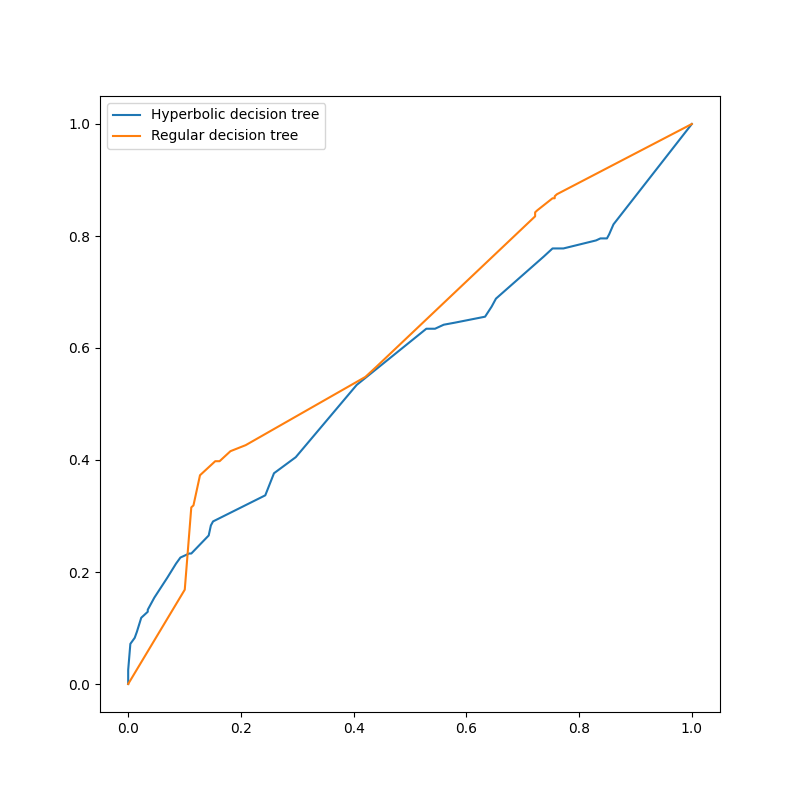

In [10]:
# ROC curve: decision trees

from sklearn.metrics import roc_curve, auc

hdt = HyperbolicDecisionTreeClassifier(**args)
hdt.fit(X_train, y_train)

dt = DecisionTreeClassifier(**args)
dt.fit(X_train, y_train)

roc = roc_curve(y_test, hdt.predict_proba(X_test)[:, 1])
roc_regular = roc_curve(y_test, dt.predict_proba(X_test)[:, 1])
fig = plt.figure(figsize=(8, 8))
plt.plot(roc[0], roc[1], label="Hyperbolic decision tree")
plt.plot(roc_regular[0], roc_regular[1], label="Regular decision tree")
plt.legend()
plt.show()


In [11]:
# ROC curve: forests

hrf = HyperbolicRandomForestClassifier(**args)
hrf.fit(X_train, y_train)

rf = RandomForestClassifier(**args)
rf.fit(X_train, y_train)

roc = roc_curve(y_test, hrf.predict_proba(X_test)[:, 1])
roc_regular = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
fig = plt.figure(figsize=(8, 8))
plt.plot(roc[0], roc[1], label="Hyperbolic random forest")
plt.plot(roc_regular[0], roc_regular[1], label="Regular random forest")
plt.legend()
plt.show()


AttributeError: 'HyperbolicRandomForestClassifier' object has no attribute 'predict_proba'

# Toy data, take 2:

In [5]:
from geomstats.geometry.hyperbolic import Hyperbolic
from src.hyperdt.conversions import convert

manifold = Hyperbolic(dim=2, default_coords_type="extrinsic")


INFO: Using numpy backend


In [6]:
# Gaussian mixture on hyperboloid:

CLUSTER_SIZES = [200, 200]
MEANS = np.array([[1.0, 0.0, 0.0], [-1.0, 0.0, 0.0]])

# Generate regular gaussian mixture
X_toy_euc = []
for cluster_size, mean in zip(CLUSTER_SIZES, MEANS):
    X_toy_euc.append(
        np.random.multivariate_normal(mean, np.eye(3), size=cluster_size)
    )
X_toy_euc = np.concatenate(X_toy_euc, axis=0)

# Project to hyperboloid
X_toy_euc_tan = manifold.logmap(X_toy_euc)


AttributeError: 'Hyperboloid' object has no attribute 'logmap'

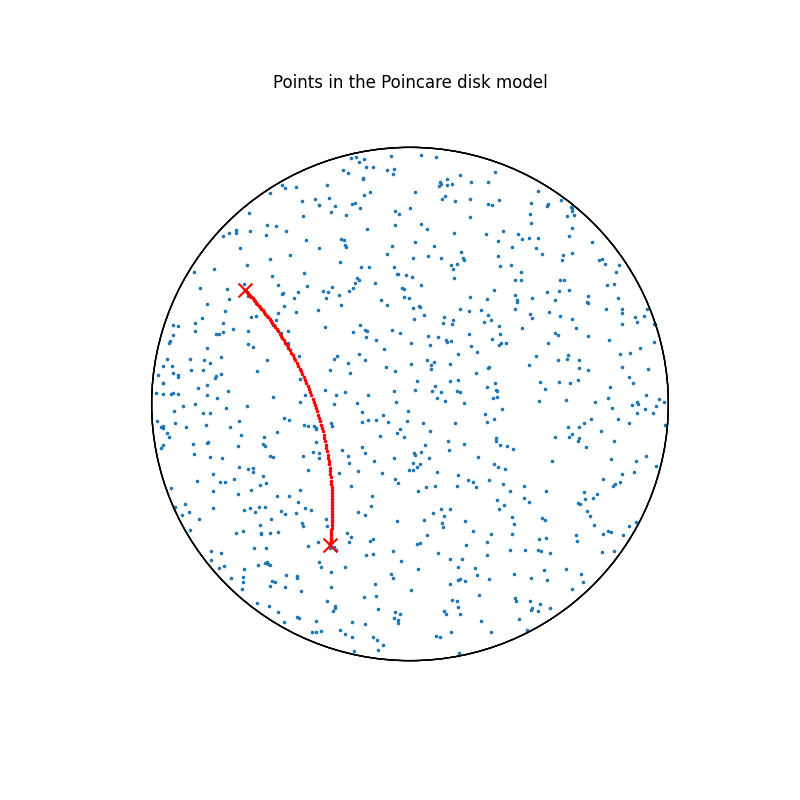

In [7]:
# Plot some points
from geomstats.visualization import plot as gplot

# Sample some random points in the unit ball
points_rejection_sampled = []
for i in range(1000):
    x = np.random.uniform(-1, 1, 2)
    if np.linalg.norm(x) < 1:
        points_rejection_sampled.append(x)

points_rejection_sampled = np.array(points_rejection_sampled)

# Project to hyperboloid
points_hyperboloid = manifold.from_coordinates(points_rejection_sampled, "ball")

# Something is weird: some points are off-manifold. Let's get rid of them
points_hyperboloid = points_hyperboloid[manifold.belongs(points_hyperboloid)]

# Get a geodesic
random_two_indices = np.random.choice(range(len(points_hyperboloid)), 2)
start_point = points_hyperboloid[random_two_indices[0]]
end_point = points_hyperboloid[random_two_indices[1]]
geodesic_func = manifold.metric.geodesic(
    initial_point=start_point, end_point=end_point
)
geodesic = geodesic_func(np.linspace(0, 1, 100))

# Plot points
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax = gplot(
    points_hyperboloid, ax=ax, space="H2_poincare_disk", marker=".", s=10
)
ax = gplot(
    np.stack([start_point, end_point]),
    ax=ax,
    space="H2_poincare_disk",
    marker="x",
    s=100,
    color="red",
)
ax = gplot(
    geodesic,
    ax=ax,
    space="H2_poincare_disk",
    marker=".",
    s=10,
    color="red",
)
ax.set_title("Points in the Poincare disk model")
plt.show()


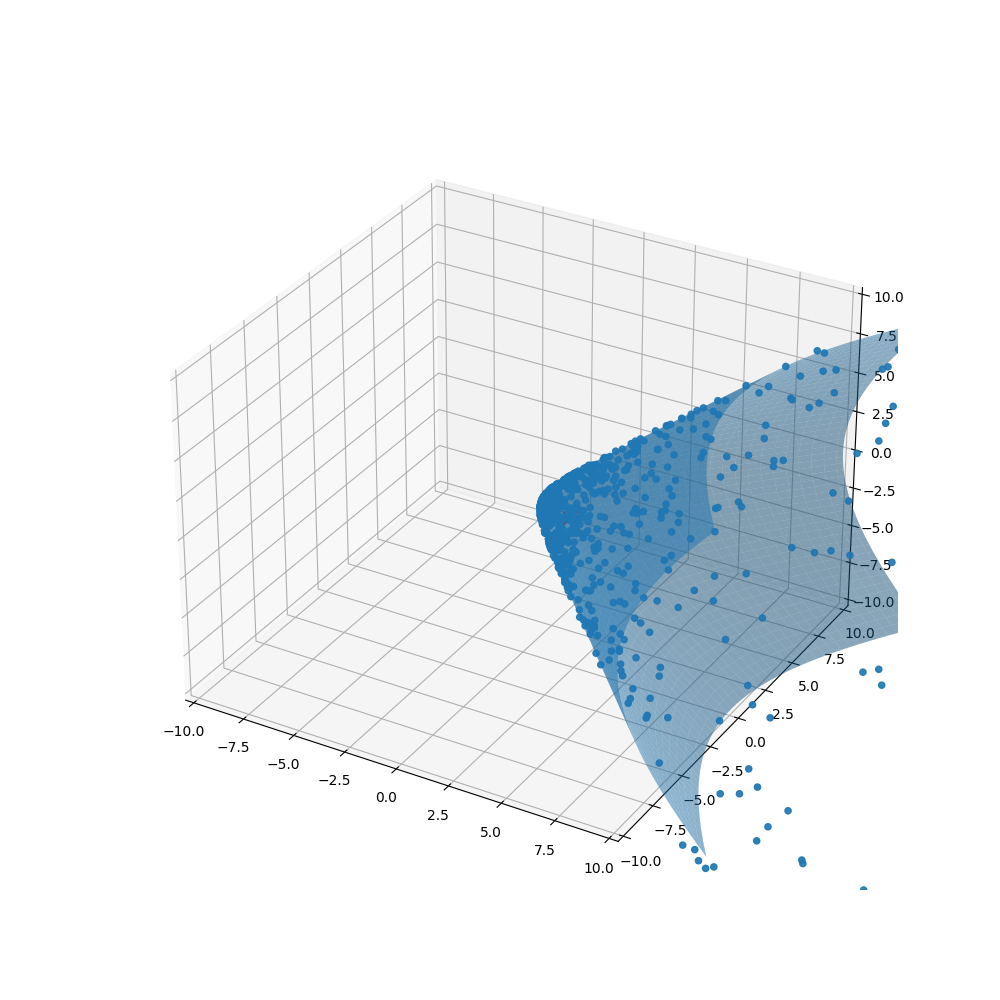

In [8]:
# For fun, let's do the same thing in the Hyperboloid model:

Z = np.linspace(-10, 10, 100)
Y = np.linspace(-10, 10, 100)
Z, Y = np.meshgrid(Z, Y)
X = np.sqrt(1 + Y ** 2 + Z ** 2)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, Z, alpha=0.5)
ax.scatter(
    points_hyperboloid[:, 0], points_hyperboloid[:, 1], points_hyperboloid[:, 2]
)
ax.scatter(
    [start_point[0], end_point[0]],
    [start_point[1], end_point[1]],
    [start_point[2], end_point[2]],
    color="red",
    marker="x",
    s=100,
)
ax.plot(
    geodesic[:, 0], geodesic[:, 1], geodesic[:, 2], color="red", linestyle="--"
)
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([-10, 10])
plt.show()


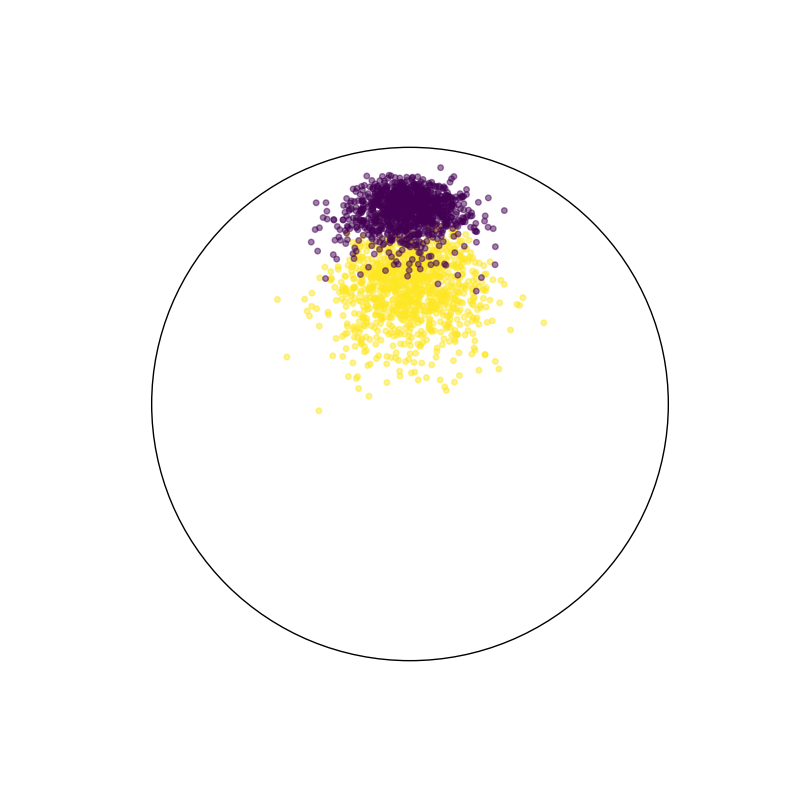

In [63]:
# Ok, now let's do a gaussian mixture exp-mapped to the manifold

gaussian_mixture_points = np.vstack(
    [
        np.random.multivariate_normal(
            mean=[0, 0, 1], cov=0.1 * np.eye(3), size=1000
        ),
        np.random.multivariate_normal(
            mean=[0, 0, 2], cov=0.1 * np.eye(3), size=1000
        ),
    ]
)

tangent_points = manifold.to_tangent(
    gaussian_mixture_points, base_point=np.array([1, 0, 0])
)

gaussian_manifold = manifold.metric.exp(tangent_points, base_point=[1, 0, 0])

colors = [1] * 1000 + [0] * 1000

# Plot on Poincecare ball
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax = gplot(
    gaussian_manifold,
    ax=ax,
    c=colors,
    s=16,
    alpha=0.5,
    cmap="viridis",
    space="H2_poincare_disk",
)


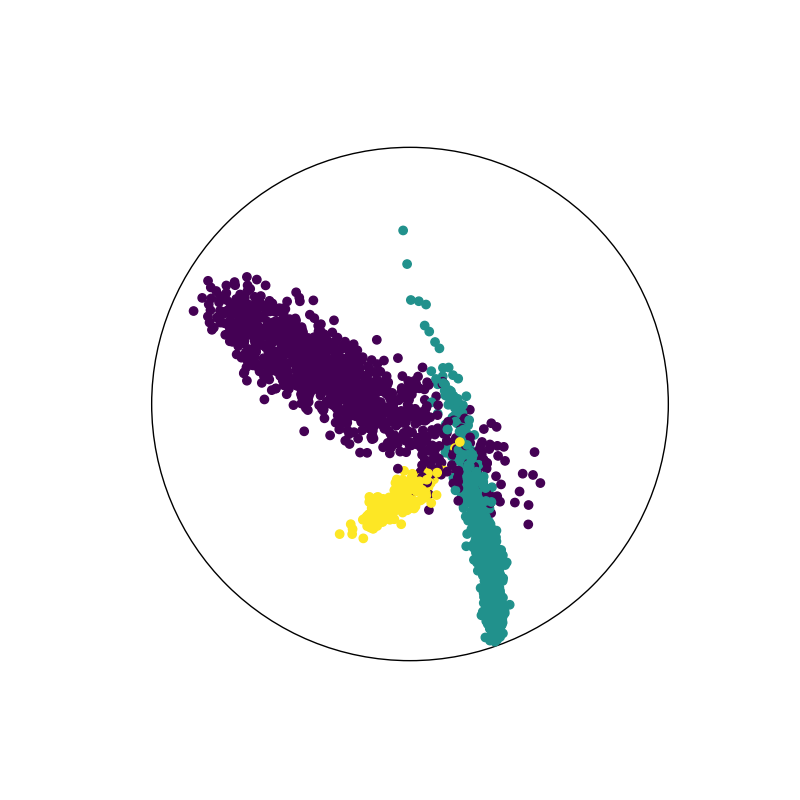

In [98]:
from src.hyperdt.toy_data import generate_gaussian_mixture_hyperboloid

X, y = generate_gaussian_mixture_hyperboloid(
    num_points=2000, num_classes=3, noise_std=0.1, seed=12
)  # Good seeds: (2 classes, 12); (4 classes, 12)

# plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax = gplot(
    X,
    c=y,
    space="H2_poincare_disk",
)
plt.show()


In [110]:
# Let's try to classify this!

from src.hyperdt.tree import HyperbolicDecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Hyperbolic decision tree
hdt = HyperbolicDecisionTreeClassifier(max_depth=3, timelike_dim=0)
hdt.fit(X_train, y_train)
print(hdt.score(X_test, y_test))

# Regular decision tree
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
print(dt.score(X_test, y_test))


0.96
0.944


In [154]:
# Let's try to do this many times:

import pandas as pd
from src.hyperdt.conversions import convert
from tqdm.notebook import tqdm

scores = pd.DataFrame(
    columns=[
        "score",
        "model",
        "n_classes",
        "n_dim",
        "n_points",
        "noise_std",
        "max_depth",
    ]
)

for i in tqdm(range(1000)):
    try:
        # Draw variables:
        max_depth = np.random.randint(1, 10)
        num_points = np.random.randint(100, 10000)
        num_classes = np.random.randint(2, 10)
        noise_std = np.random.uniform(0.0, 0.5)
        n_dim = np.random.randint(2, 16)

        # Generate dataset
        X, y = generate_gaussian_mixture_hyperboloid(
            num_points=num_points,
            num_classes=num_classes,
            noise_std=noise_std,
            n_dim=n_dim,
            default_coords_type="extrinsic",
            seed=42,
        )
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Hyperbolic
        hdt = HyperbolicDecisionTreeClassifier(max_depth=max_depth)
        hdt.fit(X_train, y_train)
        hdt_score = hdt.score(X_test, y_test)

        # Klein version
        X_train_klein = convert(X_train, "hyperboloid", "klein")
        X_test_klein = convert(X_test, "hyperboloid", "klein")
        kdt = DecisionTreeClassifier(max_depth=max_depth)
        kdt.fit(X_train_klein, y_train)
        kdt_score = kdt.score(X_test_klein, y_test)

        # Euclidean
        edt = DecisionTreeClassifier(max_depth=max_depth)
        edt.fit(X_train, y_train)
        edt_score = edt.score(X_test, y_test)

        # Save scores
        for score, model in zip(
            [hdt_score, kdt_score, edt_score], ["hdt", "kdt", "edt"]
        ):
            scores.loc[len(scores)] = {
                "score": score,
                "model": model,
                "n_classes": len(np.unique(y)),
                "n_dim": X.shape[1],
                "n_points": X.shape[0],
                "noise_std": noise_std,
                "max_depth": max_depth,
            }

    except Exception as e:
        print(e)
        continue

scores.to_csv("hyperdt_gaussian_mixture_scores.csv", index=False)


  0%|          | 0/1000 [00:00<?, ?it/s]